## Monte-Carlo Sampling, guided by Metropolis-Hastings algorithm | Gravity Inverse Problem

In [5]:
# Loading the data and checking the shape of individual matrices

import h5py
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
filename = 'gravity_data.h5'

with h5py.File(filename, "r") as f:
    G_group_key = list(f.keys())[0]
    d_group_key = list(f.keys())[1]
    print(list(f.keys()))
    G = np.array(f[G_group_key])
    d = np.array(f[d_group_key])

print("Shape: ",G.shape, d.shape)

['G', 'd']
Shape:  (20301, 201) (201,)


It can be seen that the shape of the matrix G is 20301x201, we need to atleast transpose it and use. After transposing the matrix will have same number of rows as in the data matrix i.e 201

In [6]:
G_ = np.transpose(G)
print(G_.shape)

(201, 20301)


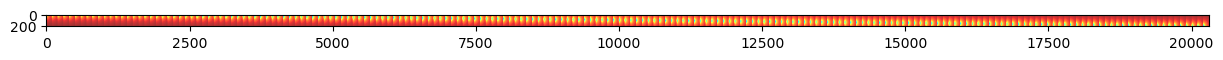

In [7]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(G_, alpha=0.8, cmap='jet')
plt.show()

In [8]:
def scale(arr):
    arr = arr / np.min(G_)
    return arr

x = G_
y = d

## Elastic Net

Solution through Elastic Net is kept in order to compare it with the solution through Monte Carlo Sampling.

This module optimizes the following cost function

$$J = \frac{1}{(2 * n_{samples})} * {{||y - Xw||_{2}^2}} + \alpha * {l1}_{ratio} * {||w||}_{1} + {\frac{1}{2}} * \alpha * (1 - l1_{ratio}) * {{||w||}_{2}}^2$$


In [284]:
from sklearn.linear_model import enet_path
from sklearn.metrics import r2_score

num_alphas=100
# alpha_list = np.arange(3,0.01,-0.01)
#alphas_enet,coefs_enet,b = enet_path(scale(x),scale(y), alphas=alpha_list, l1_ratio=0.5)

alphas_enet,coefs_enet,b = enet_path(scale(x),scale(y), n_alphas=num_alphas, l1_ratio=0.99, eps=1e-4, verbose=True)
print(alphas_enet.shape,coefs_enet.shape)

r2_scores_enet = []
for i in range(0,num_alphas):
    m_enet = coefs_enet[:,i]
    m_enet_reshaped = np.reshape(coefs_enet[:,i],(101,201), order = 'F')
    d_enet_pred = G_@m_enet
    r2_score_enet = r2_score(d, d_enet_pred)
    r2_scores_enet.append(r2_score_enet)

    
print("Last 5 values of alpha and accuracy for ElasticNet path")
for i in range(num_alphas-5,num_alphas):
    print('R2 Score = ',r2_score_enet,'alpha = ',alphas_enet[i], 'index = ',i)

....................................................................................................

(100,) (20301, 100)
Last 5 values of alpha and accuracy for ElasticNet path
R2 Score =  0.9999939817193622 alpha =  0.15131312988599538 index =  95
R2 Score =  0.9999939817193622 alpha =  0.13787088846338463 index =  96
R2 Score =  0.9999939817193622 alpha =  0.12562281872038866 index =  97
R2 Score =  0.9999939817193622 alpha =  0.11446283373626587 index =  98
R2 Score =  0.9999939817193622 alpha =  0.10429427105992507 index =  99


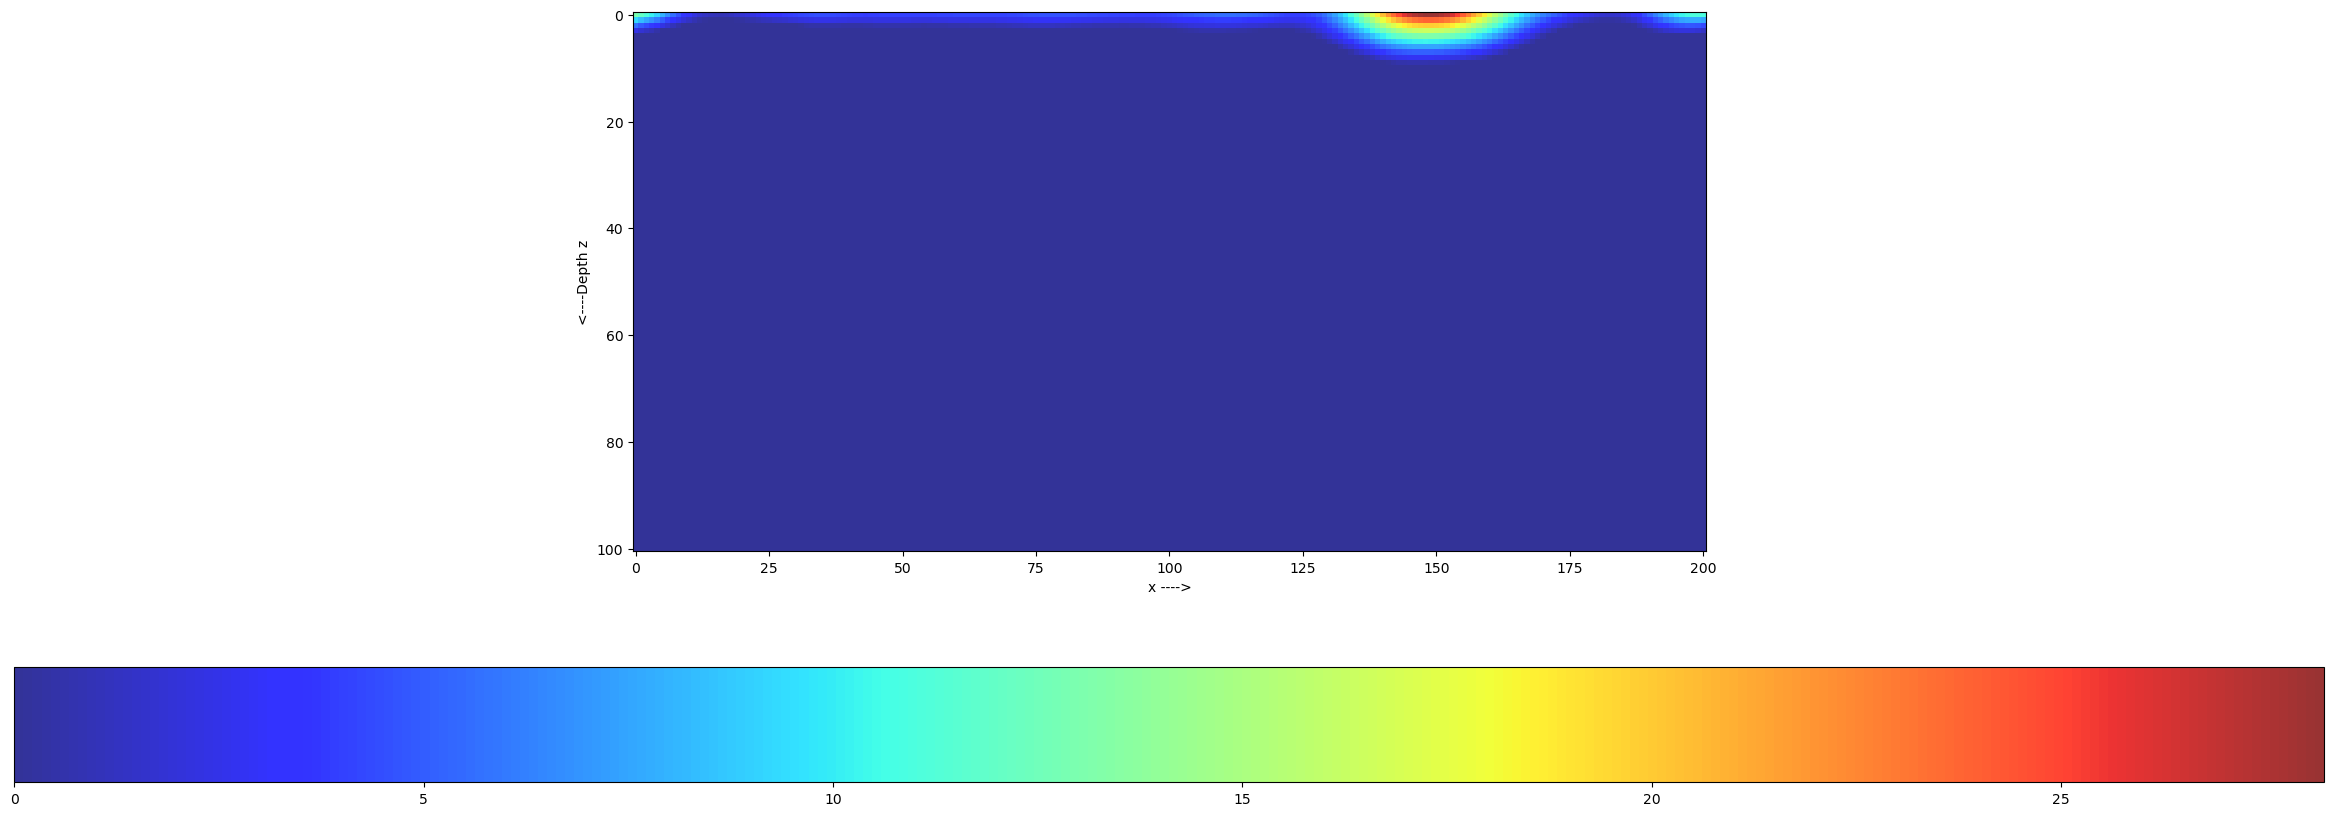

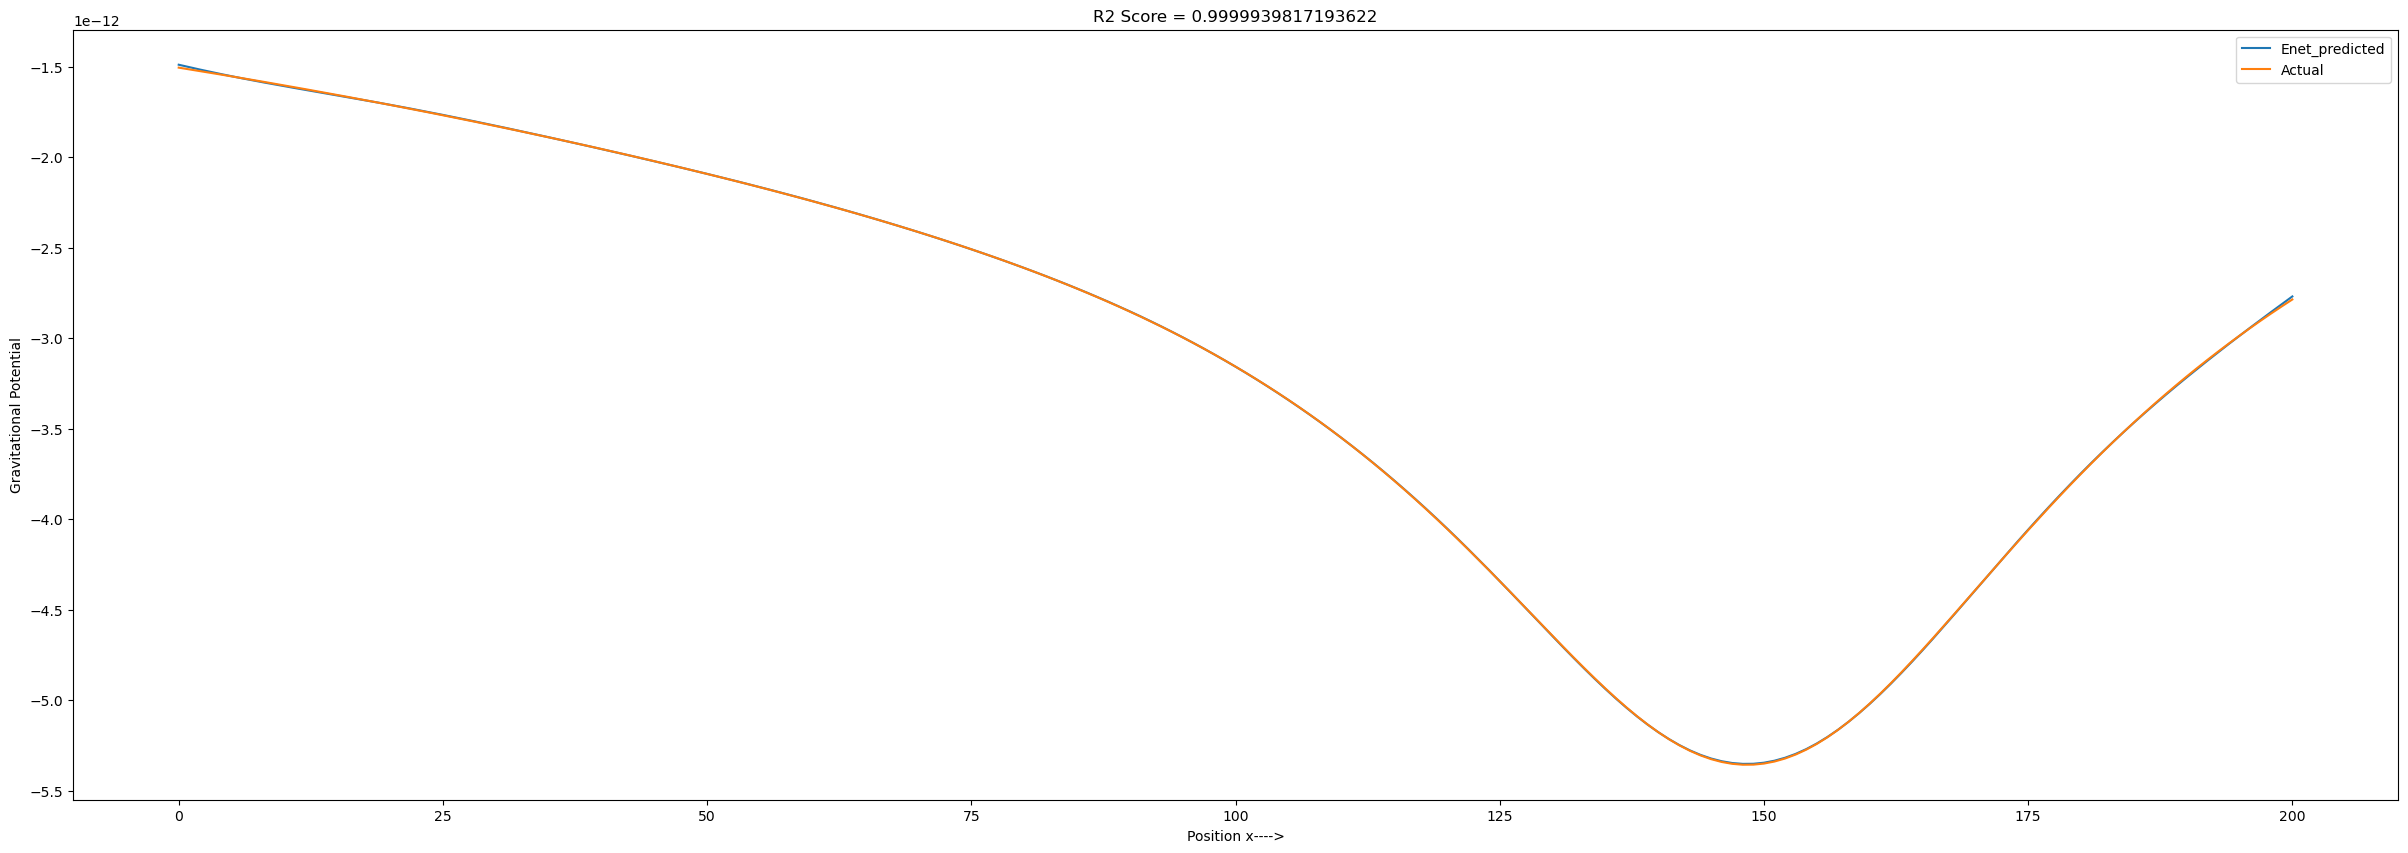

In [285]:
m_enet = coefs_enet[:,num_alphas-1]
m_enet_reshaped = np.reshape(m_enet,(101,201), order = 'F')
d_enet_pred = G_@m_enet

plt.imshow(m_enet_reshaped, alpha=0.8, cmap='jet')
plt.xlabel('x ---->')
plt.ylabel('<----Depth z')
plt.colorbar(location = 'bottom')
plt.show()

x_km = np.arange(0,201,1)
plt.plot(x_km,d_enet_pred, label = 'Enet_predicted')
plt.plot(x_km,d, label='Actual')
plt.legend()
plt.xlabel('Position x---->')
plt.ylabel('Gravitational Potential')
plt.title('R2 Score = '+str(r2_score(d, d_enet_pred)))
plt.show()

Elastic net only provide us a solution with positive density anomaly at $x = 150$ units and a spread at the surface. As already found out earlier this is a underdetermined problem it has infinite number of solutions in which rather than density being concentrated at a region it is spread out/scattered and discontinuous. 

## Monte Carlo Sampling

To make it more determined and solvable we need prior information, which are:
1) There are 2 separate blocky anomalies(No intersection)
2) Constraints such as density lying between $0-100 \frac{Kg}{m^3}$

## 1(i) Sampling the Prior Distribution
Functions are written to generate rectangular and elliptical anomalies. The cells that fall within the boundary of the rectangle/ellipse are alloted a fixed density value.

In [11]:
#Generate the initial sample containing 2 Rectangular/Elliptical density blocks

import pandas as pd

# Generate elliptical anomalies/ Ellipses are more general compared to a circle.
def gen_ellipse(row_c,col_c,a,b,density,array_initial):
    m_r = np.copy(array_initial)
    for i in range(0,101):
        for j in range(0,201):
            d = (((i-row_c)/a)**2 + ((j-col_c)/b)**2)
            if(d-1<=0):
                m_r[i,j] = density     # The cells that fall within the bound of the ellipse are alloted a fixed density value
    return m_r

# Generate rectangular anomalies
def gen_rectangular(row_c,col_c,a,b,density,array_initial):
    m_r = np.copy(array_initial)
    for i in range(0,101):
        for j in range(0,201):
            if(abs(row_c-i)<=a/2 and abs(col_c-j)<=b/2):
                m_r[i,j] = density   # The cells that fall within the bound of the rectangle are alloted a fixed density value
    return m_r




def gen_block_2(n_samples, min_density, max_density, min_size, max_size):   
    
    # Making an array for each parameter that defines the block, 'n_samples' corresponds to the dimension of the array.
    densities = np.random.randint(min_density, max_density, size = n_samples)
    row_c = np.random.randint(0, 101, size=n_samples) # The bounds 101 and 201 correspond to the length and width of the grid.
    col_c =np.random.randint(0,201,size=n_samples)
    a = np.random.randint(min_size, max_size, size=n_samples)
    b = np.random.randint(min_size, max_size, size=n_samples)
    
    # For the 2nd block
    densities_2 = np.random.randint(min_density, max_density, size = n_samples)
    row_c_2 = np.random.randint(0,101,size=n_samples)
    col_c_2 =np.random.randint(0,201,size=n_samples)
    a_2 = np.random.randint(min_size, max_size, size=n_samples)
    b_2 = np.random.randint(min_size, max_size, size=n_samples)
    # This second rectangle can intersect with the first if no other condiotn is used
    
    t = 0  #This will be changed to 'n_samples' when the we get a sample which is not intersecting with the previous one
        
    while(t<n_samples):   #This will run till all samples satisfy the condtion of no intersection
        
        if(abs(row_c[t] - row_c_2[t])>=((a[t] + a_2[t])/2) or abs(col_c[t] - col_c_2[t])>=((b[t] + b_2[t])/2)):
            t +=1
        else:
            # If the condtion is not satisfied we generate again
            densities_2[t] = np.random.randint(min_density, max_density)
            row_c_2[t] = np.random.randint(0,101)
            col_c_2[t] =np.random.randint(0,201)
            a_2[t] = np.random.randint(min_size, max_size)
            b_2[t] = np.random.randint(min_size, max_size)
            
            



    Collections = np.zeros((n_samples,101,201))
    Collection_properties = np.zeros((n_samples, 2,5))  
    # Will store the properties of the randomly generated sample such as center/size etc

    m_init = np.zeros((101,201))
    for i in range(n_samples):
        first_rectangular_filled = gen_rectangular(row_c[i],col_c[i],a[i],b[i],densities[i],m_init)
        Collections[i,:,:] = gen_rectangular(row_c_2[i],col_c_2[i],a_2[i],b_2[i],densities_2[i],first_rectangular_filled)
        Collection_properties[i,0,:] = np.array([row_c[i],col_c[i],a[i],b[i],densities[i]]) #First rectangle properties
        Collection_properties[i,1,:] = np.array([row_c_2[i],col_c_2[i],a_2[i],b_2[i],densities_2[i]]) #2nd rectangle properties
        
    return Collections, Collection_properties


100 Samples are generated to test how the prior samples will look

In [144]:
## Parameters for random generation
min_density = 0
max_density = 100
min_size = 10
max_size = 50

Plots of random 100 samples


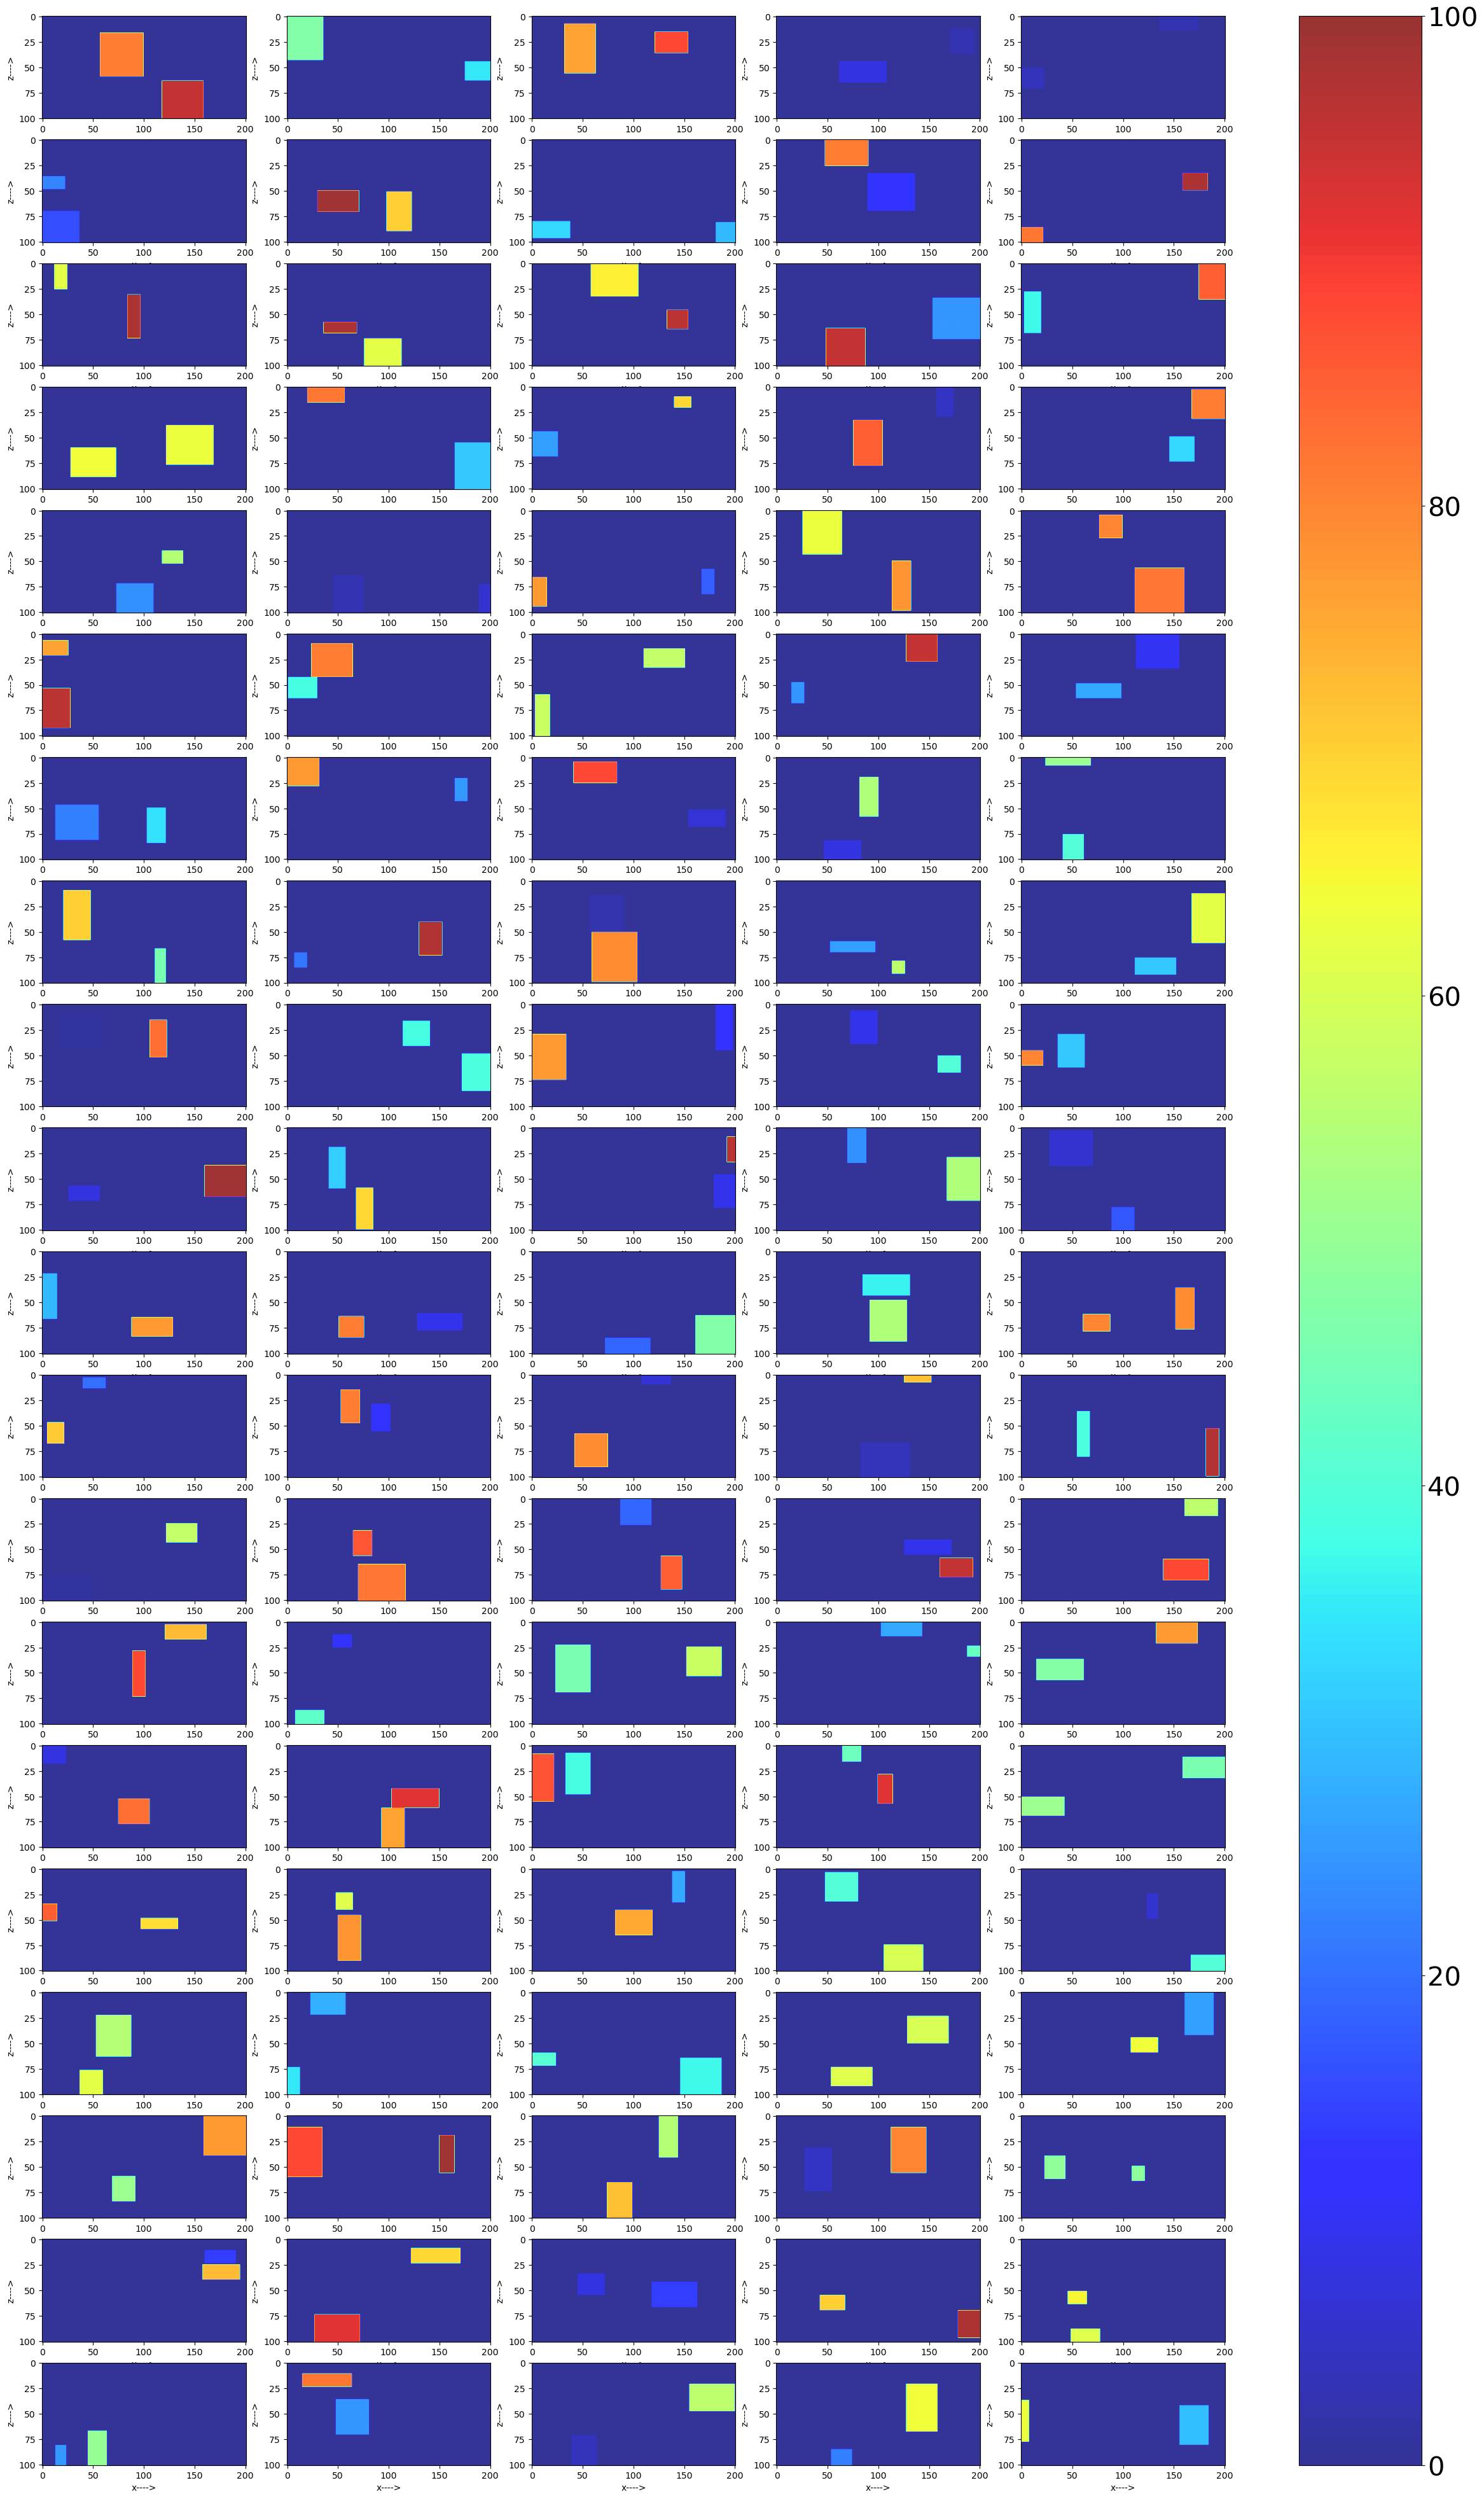

In [159]:
#only for plotting
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 50]

num_samples = 100    # N.o of samples to plot

fig,ax = plt.subplots(int(num_samples/5),5)
row = 0
col = 0
count = 0
print("Plots of random {} samples".format(num_samples))
# plt.rcParams['figure.figsize'] = [80,100]



Collections, Collection_properties = gen_block_2(n_samples=num_samples,
                                       min_density = min_density,
                                       max_density = max_density, 
                                       min_size = min_size, 
                                       max_size = max_size) #Generating 100 samples

#Plotting alternate rows due to space constraint
for i in range(num_samples):
    im = ax[row,col].imshow(Collections[i,:,:], alpha=0.8, cmap='jet',vmin=min_density,vmax=max_density)
#     ax[row,col].set_title('Count = '+str(count+1))
    ax[row,col].set_xlabel('x---->')
    ax[row,col].set_ylabel('z---->')
    count+=1
    row = int(count/5) #This part is used to find the index of the plot given 5 plots per row.
    col = int(count%5)


cbar = plt.colorbar(im, ax=ax.ravel().tolist()) 
cbar.ax.tick_params(labelsize=30)
plt.show()

## 1(ii) The Gaussian prior for data

Referring Tarantola(Inverse problem theory) book and "Monte Carlo sampling of solutions to inverse problems" paper.

$\sigma(m)$ being the posterior distribution for the model, $L(m)$ the Likelihood function models the uncertainity in $d_{observed}$ as well as how probable is the model given the misfit.

$\sigma(m) = k*L(m)*\rho(m)$

For the case of constant variance, covariance matrix is a diagonal matrix, the likelihood function degenerates into:

$L(m) = k*exp(-\frac{S(m)}{s^2})$ , s is the noise/uncertainity in the data

$S(m)$ is the misfit function given by $S(m) = \frac{1}{2}\sum{(g^i(m) - {d^i}_{obs})^2}$ , this is basically the L2 norm

In [146]:

# The data is in the order of 1e-12 hence scaling is used in order to get a usable value for the misfit function
def scale_2(arr):
    arr = arr / 5e-12
    return arr


def Likelihood_m(d_pred,d_obs,d_sd):
    
    CD = ((d_sd**2)*np.identity(201))
    
    CD_inv = np.linalg.inv(CD)
    
    k1 = 1
    
    d_pred_scaled = scale_2(d_pred) #To prevent very high or low values for the misfit function
    d_obs_scaled = scale_2(d_obs)
    S = ((d_pred_scaled - d_obs_scaled).T @ (d_pred_scaled - d_obs_scaled)) / 2 #Misfit Function
    
    
    k2 = - S / (d_sd**2)     #Degenerate case, Refer Tarantola Paper eq:15
    
    
    p_d_m = k1*np.exp(k2)
    
    return p_d_m

## Perturbation with the criteria: 
1) Non intersection of 2 rectangles
2) Size and Density shouldn't go beyond the bounds specified.
3) The centers of each should remain with the bounds.

An example showing how the function works


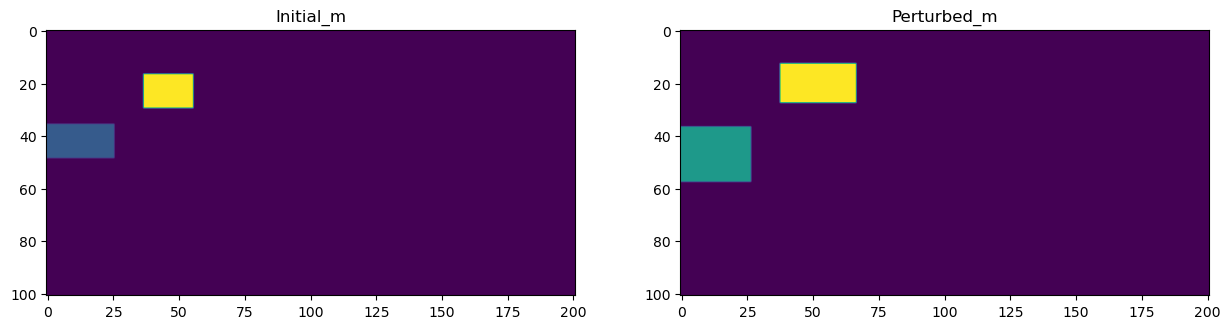

In [147]:
#initial m generated

plt.rcParams['figure.figsize'] = [15, 15]

m0_, properties_m0_ = gen_block_2(n_samples=1,
                                       min_density = min_density,
                                       max_density = max_density, 
                                       min_size = min_size, 
                                       max_size = max_size)
m0 = m0_[0]
properties_m0 = properties_m0_[0]




#         center_row  center_column  Length  Width  Density
# rect-1         9.0          123.0    12.0    3.0     21.0
# rect-2         5.0          144.0    27.0   15.0     67.0

#For reference of which index corresponds to what

# A function that will perturb the properties of m and return the new properties
def perturb_m_parameters(properties_m, sigma_center, sigma_density, sigma_size):
    
    # Copying the values for block 1
    block1_r = properties_m[0,0]
    block1_c = properties_m[0,1]
    block1_a = properties_m[0,2]
    block1_b = properties_m[0,3]
    block1_density = properties_m[0,4]
    
    # Copying the values for block 2
    block2_r = properties_m[1,0]
    block2_c = properties_m[1,1]
    block2_a = properties_m[1,2]
    block2_b = properties_m[1,3]
    block2_density = properties_m[1,4]
    
    # Generation perturbations for the 1st block
    delta_block1_r = int(sigma_center*np.random.randn())
    delta_block1_c = int(sigma_center*np.random.randn())
    delta_block1_a = sigma_size*np.random.randn()
    delta_block1_b = sigma_size*np.random.randn()
    delta_block1_density = sigma_density*np.random.randn()
    
    # Adding perturbations for the 1st block
    new_block1_r = block1_r + delta_block1_r
    new_block1_c = block1_c + delta_block1_c
    new_block1_a = block1_a + delta_block1_a
    new_block1_b = block1_b + delta_block1_b
    new_block1_density = block1_density + delta_block1_density
    
    #Size and density constrains need to be checked and corrected
#     If statements are taking care of the following:

#     1) Non intersection of 2 rectangles
#     2) Size and Density shouldn't go beyond the bounds specified.
#     3) The centers of each should remain with the bounds.
    
    t = 0
    
    while(t<1):
        if(new_block1_r >= 0 and new_block1_r <= 101):
            
            if(new_block1_c >= 0 and new_block1_c <= 201):
           
                if(new_block1_a >= min_size and new_block1_a <= max_size):

                    if(new_block1_b >= min_size and new_block1_b <= max_size):

                        if(new_block1_density >= min_density and new_block1_density <= max_density):

                            t = 1 # All condtions satisfied

                        else:
                            
                            new_block1_density = block1_density + sigma_density*np.random.randn()
                    else:
                        
                        new_block1_b = block1_b + sigma_size*np.random.randn()
                else:
                    
                    new_block1_a = block1_a + sigma_size*np.random.randn()
            else:
                
                new_block1_c = block1_c + int(sigma_center*np.random.randn())
                
        else:
            new_block1_r = block1_r + int(sigma_center*np.random.randn())
    
    
    
    # Generation perturbations for the 2nd block
    delta_block2_r = int(sigma_center*np.random.randn())
    delta_block2_c = int(sigma_center*np.random.randn())
    delta_block2_a = sigma_size*np.random.randn()
    delta_block2_b = sigma_size*np.random.randn()
    delta_block2_density = sigma_density*np.random.randn()
    
    # Adding perturbations to the 2nd block
    new_block2_r = block2_r + delta_block2_r
    new_block2_c = block2_c + delta_block2_c
    new_block2_a = block2_a + delta_block2_a
    new_block2_b = block2_b + delta_block2_b
    new_block2_density = block2_density + delta_block2_density
    
    # The 2nd rectangle after perturbing should obey the constraint of:
    # Non intersection(this was not used in block 1)
    # Within the bounds of size and density
    
    
    # Multiple if statments are stacked to make it more interpretable
    t = 0
    while(t<1):
        
        if((abs(new_block1_r - new_block2_r)>=((new_block1_a + new_block2_a)/2) or # Non intersection
           abs(new_block1_c - new_block2_c)>=((new_block1_b + new_block2_b)/2)) and
           (new_block2_r >= 0 and new_block2_r <= 101 and new_block2_c >= 0 and new_block2_c <= 201)): # and bounds criteria
            
            if(new_block2_a >= min_size and new_block2_a <= max_size):  # Length criteria
                
                if(new_block2_b >= min_size and new_block2_b <= max_size): # Breadth criteria
                    
                    if(new_block2_density >= min_density and new_block2_density <= max_density): # Density criteria
                        
                        t = 1 # All condtions satisfied
                        
                    else:
                        new_block2_density = block2_density + sigma_density*np.random.randn()
                        
                else:
                    new_block2_b = block2_b + sigma_size*np.random.randn()
            
            else:
                new_block2_a = block2_a + sigma_size*np.random.randn()
                
        else:
            new_block2_r = block2_r + int(sigma_center*np.random.randn())
            new_block2_c = block2_c + int(sigma_center*np.random.randn())
                            
                      
    
    properties_m_new = np.zeros((2,5))
    properties_m_new[0,0] = new_block1_r
    properties_m_new[0,1] = new_block1_c
    properties_m_new[0,2] = new_block1_a
    properties_m_new[0,3] = new_block1_b
    properties_m_new[0,4] = new_block1_density
    
    properties_m_new[1,0] = new_block2_r
    properties_m_new[1,1] = new_block2_c
    properties_m_new[1,2] = new_block2_a
    properties_m_new[1,3] = new_block2_b
    properties_m_new[1,4] = new_block2_density
    
    return properties_m_new


def gen_m_with_perturbation(properties_m_initial, sigma_center, sigma_density, sigma_size):
    
    properties_m_new = perturb_m_parameters(properties_m_initial, sigma_center, sigma_density, sigma_size)
    blank_array = np.zeros((101,201))
    
    block_1_added = gen_rectangular(properties_m_new[0,0],properties_m_new[0,1],properties_m_new[0,2],properties_m_new[0,3],
                                    properties_m_new[0,4],blank_array)
    
    block_2_added = gen_rectangular(properties_m_new[1,0],properties_m_new[1,1],properties_m_new[1,2],properties_m_new[1,3],
                                    properties_m_new[1,4],block_1_added)
    
    return block_2_added, properties_m_new


## Check to see if the functions are working

m_new, new_properties = gen_m_with_perturbation(properties_m0, sigma_center=10, sigma_density=10, sigma_size=5)

fig,ax = plt.subplots(1,2)
ax[0].imshow(m0)
ax[0].set_title('Initial_m')
ax[1].imshow(m_new)
ax[1].set_title('Perturbed_m')
print('An example showing how the function works')
plt.show()


## 2) Employing Metropolis Hastings to sample the posterior distribution

The G matrix is used whenever the likelihood is to be calculated: $d_{pred} = G.m_{sampled}$

Rules employed for metropolis hastings:

1) If $L(m_j) \ge L(m_i)$ , then the proposition is accepted
2) If $L(m_j) < L(m_i)$ then randomly decide whether to accept the $m_j$ using a bernoulli trial with $P_{success} = \frac{L(m_j)}{L(m_i)}$

[Inverse Problem Theory, Tarantola 2005]

In [197]:
import numpy as np
from scipy.stats import bernoulli
np.random.seed(99)

def random_walk_metropolis(toggle_metro, dependent, m0, properties_m0, d_obs, 
                           sigma_center, sigma_density, sigma_size, d_sigma, n_samples):
    
    # m needs to flatted in order to use d = Gm
    m0_reshaped = np.reshape(m0,(20301),order='F')
    d_pred_0 = G_ @ m0_reshaped  
    
    Likelyhood_m0 = Likelihood_m(d_pred_0,d_obs,d_sigma) # Likelihood of the initial m0, the starting sample
    
    # Variables to calculate the acceptance ratio
    count_all_generations = 0
    count_samples_chosen = 0
    
    m_sample_store = np.zeros((n_samples,101,201))
    store_Likelihoods = np.zeros((n_samples))
    store_properties = np.zeros((n_samples,2,5))
    
    
    L_i = Likelyhood_m0 #Likelyhood of initial m
    
    m_i = m0
    prop_m_i = properties_m0
    
    while(count_samples_chosen < n_samples):
        
    
        
        # Perturb the current sample to produce a new one
        if(dependent == 1):
            m_j, prop_m_j = gen_m_with_perturbation(prop_m_i, sigma_center, sigma_density, sigma_size)
            count_all_generations += 1   #Generation followed by counting
        
        # Independent Sampling by generation 2 blocks randomly
        else:
            m_j_, prop_m_j_ = gen_block_2(n_samples = 1,
                                       min_density = min_density,
                                       max_density = max_density, 
                                       min_size = min_size, 
                                       max_size = max_size) #Generating 100 samples
            m_j = m_j_[0]
            prop_m_j = prop_m_j_[0]
            
            count_all_generations += 1   #Generation followed by counting
        
        
        
        
        
        d_pred_j = G_ @ (np.reshape(m_j,(20301),order='F'))
        L_j = Likelihood_m(d_pred_j, d_obs, d_sigma)
        
        
        if(L_i > 0): # To avoid division by 0 error
            P_metropolis_ratio = L_j/L_i
        else:
            P_metropolis_ratio = 1
            

        # Case 1, just accept the proposal
        if(P_metropolis_ratio>=1):
            m_sample_store[count_samples_chosen,:,:] = m_j
            prop_m_i = prop_m_j
            L_i = L_j
            store_properties[count_samples_chosen,:,:] = prop_m_j
            store_Likelihoods[count_samples_chosen] = L_j
            
            count_samples_chosen += 1
        # Case 2, use a bernoulli trial to accept/reject    
        else:
            #print(P_metropolis_ratio)
            if(bernoulli(min(1,P_metropolis_ratio)).rvs() and toggle_metro == 1):
                m_sample_store[count_samples_chosen,:,:] = m_j
                prop_m_i = prop_m_j
                L_i = L_j 
                store_properties[count_samples_chosen,:,:] = prop_m_j
                store_Likelihoods[count_samples_chosen] = L_j
                
                count_samples_chosen += 1
    
    acceptance_ratio = count_samples_chosen / count_all_generations
    
    
    return [m_sample_store, store_Likelihoods, acceptance_ratio, store_properties]
        

Initial m0 is defined, we could have used a random start, output will change each time we run the code.

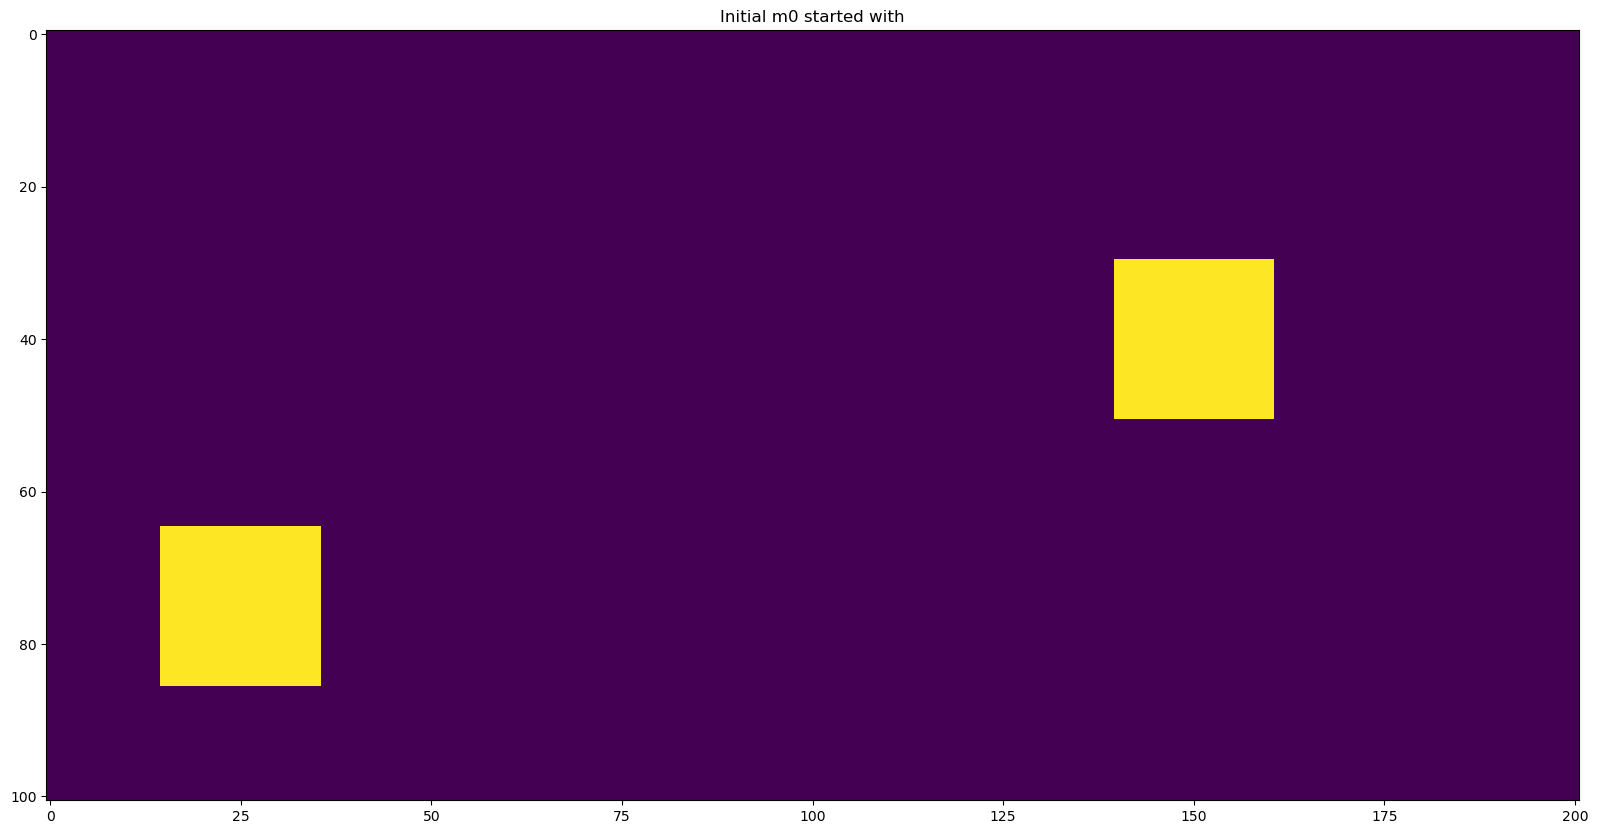

In [273]:
# Initial m0 generated

#            center_row  center_column     Length      Width    Density
# rect-1        75              25           20        20         50
# rect-2        40             150           20        20         50


blank_array = np.zeros((101,201))
    
block_1_added = gen_rectangular(75, 25, 20, 20, 50,blank_array)
block_2_added = gen_rectangular(40, 150, 20, 20, 50 ,block_1_added)

properties_m0 = np.zeros((2,5))
properties_m0[0,:] = np.array([75, 25, 20, 20, 50])
properties_m0[1,:] = np.array([40, 150, 20, 20, 50])


m0 = block_2_added

plt.imshow(m0)
plt.title('Initial m0 started with')
plt.show()

## Dependent sampling: (Random perturbation on the previous sample)

In [274]:
# Setting Dependent = 1 for the random_walk_metropolis function

plt.rcParams['figure.figsize'] = [15, 15]
num_samples =  500  #Number of samples to generate, runtime will increase as samples are increased

Output = random_walk_metropolis(toggle_metro = 1,  # turn the 2nd case on/off, '0' is take only the samples with more likelihood
                                dependent = 1, # Dependent on the previous sample, perturbation to previous gives new sample
                                m0 = m0, 
                                properties_m0 = properties_m0, 
                                d_obs = d, 
                                sigma_center = 8, # Uncertainity in the centres of rectangle
                                sigma_density = 10, # Uncertainity in density
                                sigma_size = 1, # Uncertainity in size of the the rectangles
                                d_sigma = 2, # Standard deviation in data(Note this value works on the scaled data)
                                n_samples = num_samples)

m_array, l_values, acceptance_ratio, properties_array = Output[0],Output[1],Output[2],Output[3]


Plotting the top 5 samples with the highest likelihoods:

Acceptance ratio 0.3785011355034065


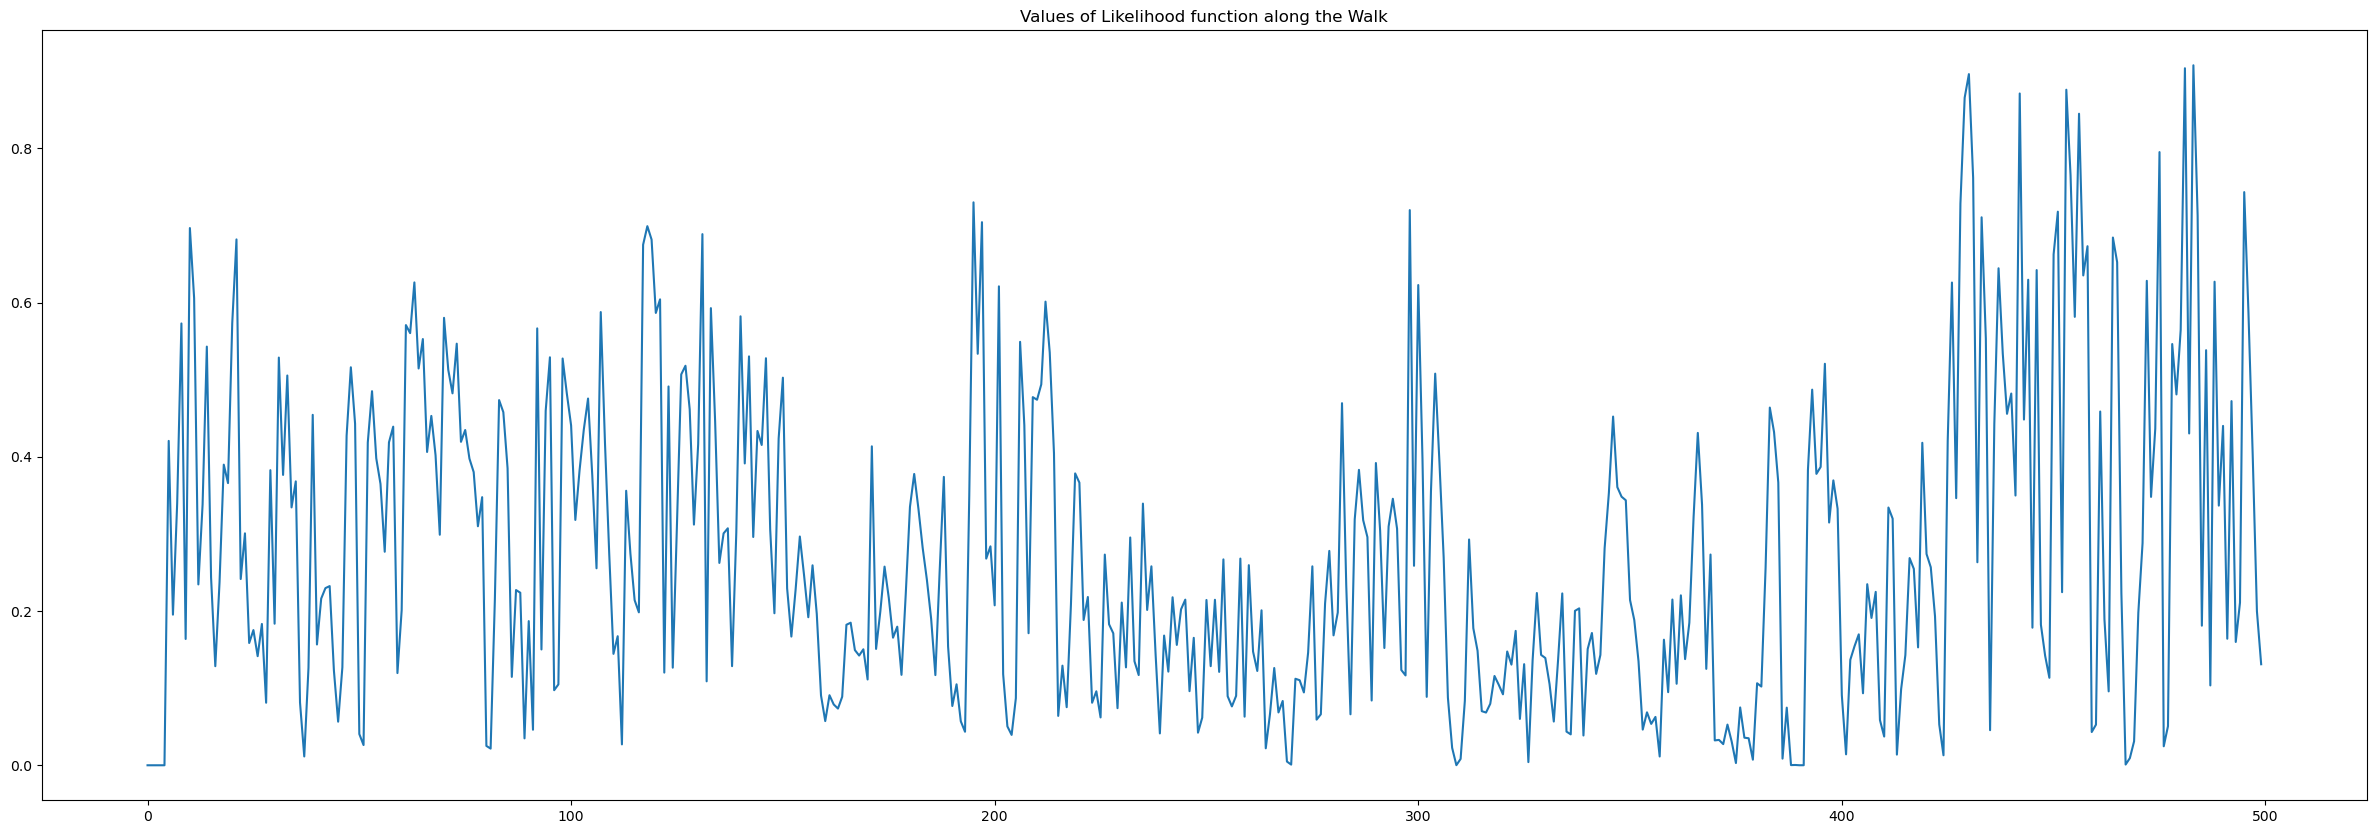

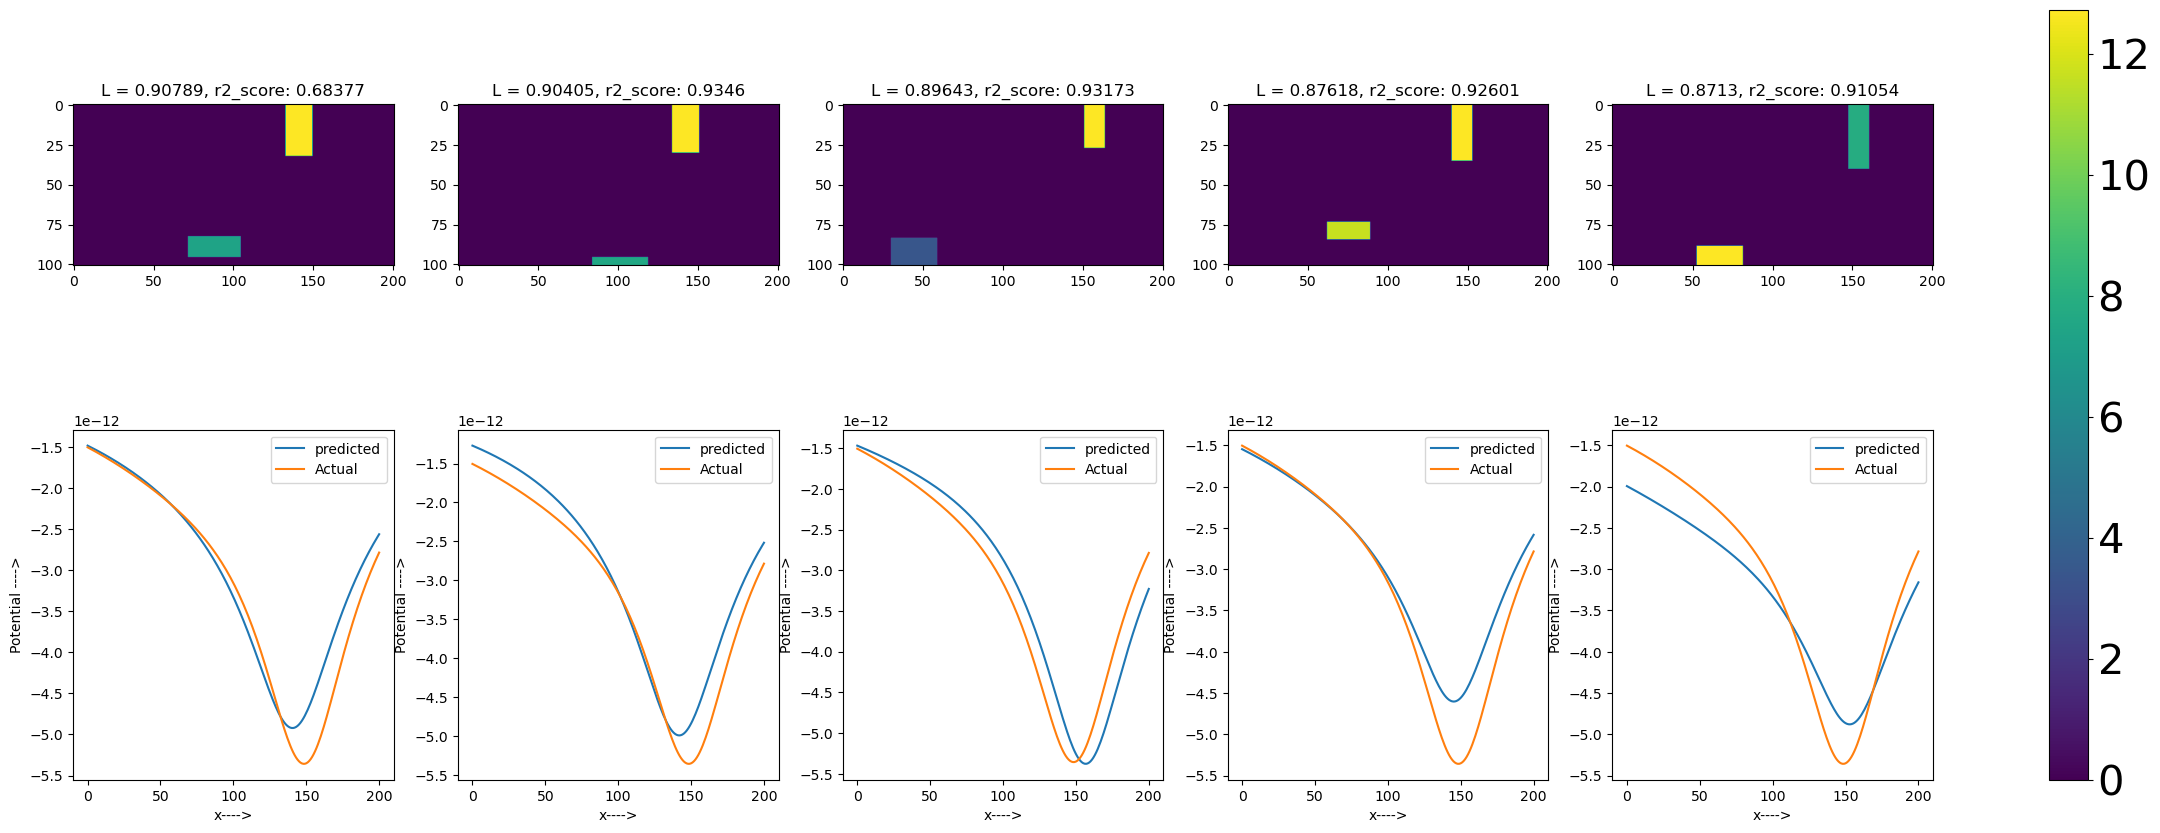

In [275]:
# Use the value that has the highest likelihood for the plots
from sklearn.metrics import r2_score
L_max = np.max(l_values)

plt.rcParams['figure.figsize'] = [30, 10]

print("Acceptance ratio {}".format(acceptance_ratio)) #Print the acceptance ratio

plt.plot(l_values)
plt.title('Values of Likelihood function along the Walk')  #Plot how the values of likelihood changed along the selected samples
plt.show()

index_sorted_L_array = np.argsort(l_values)  # Sorting and storing in ascending order

fig,ax = plt.subplots(2,5)

x_km = np.arange(0,201,1)

for i in range(1,6,1):
    m_pred = m_array[index_sorted_L_array[-i],:,:]
    im = ax[0,i-1].imshow(m_pred)
    ax[0,i-1].set_title('L = {}, r2_score: {}'.format(round(l_values[index_sorted_L_array[-i]],5),
                                                      round(r2_score(d, d_pred),5)))
    
    d_pred = G_ @ (np.reshape(m_pred,(20301),order='F'))
    
    ax[1,i-1].plot(x_km,d_pred, label = 'predicted')
    ax[1,i-1].plot(x_km,d, label='Actual')
    ax[1,i-1].set_xlabel('x---->')
    ax[1,i-1].set_ylabel('Potential ---->')
    ax[1,i-1].legend()

cbar = plt.colorbar(im, ax = ax.ravel().tolist())
cbar.ax.tick_params(labelsize=30)
plt.show()   



In [276]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def Plot_walk(index):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(m_array[index])
    ax[0].set_title('Random walk through model space, Selected m index {}'.format(index+1))
    
    d_pred = G_ @ (np.reshape(m_array[index],(20301),order='F'))
    
    ax[1].plot(x_km,d, label='Actual')
    ax[1].plot(x_km,d_pred, label='Predicted')
    ax[1].set_xlabel('x---->')
    ax[1].set_ylabel('Potential ---->')
    plt.legend()

print("Slider: ")
interact(Plot_walk, index=(0,num_samples-1,1))

Slider: 


interactive(children=(IntSlider(value=249, description='index', max=499), Output()), _dom_classes=('widget-int…

<function __main__.Plot_walk(index)>

## Independent sampling: Every iteration a new sample is generated

In [277]:
# Setting dependent = 0 will correspondingly go to the else statement.

plt.rcParams['figure.figsize'] = [15, 15]
num_samples =  50  # Acceptance ratio is very low for independent sampling hence this this is kept small.

Output = random_walk_metropolis(toggle_metro = 1,  # turn the 2nd case on/off, '0' is take only the samples with more likelihood
                                dependent = 0, # Dependent on the previous sample, perturbation to previous gives new sample
                                m0 = m0, 
                                properties_m0 = properties_m0, 
                                d_obs = d, 
                                sigma_center = 8, # Uncertainity in the centres of rectangle
                                sigma_density = 10, # Uncertainity in density
                                sigma_size = 1, # Uncertainity in size of the the rectangles
                                d_sigma = 2, # Standard deviation in data(Note this value works on the scaled data)
                                n_samples = num_samples)

m_array, l_values, acceptance_ratio, properties_array = Output[0],Output[1],Output[2],Output[3]



Plotting the samples with top 5 likelihood:

Acceptance ratio 0.012830382345393894


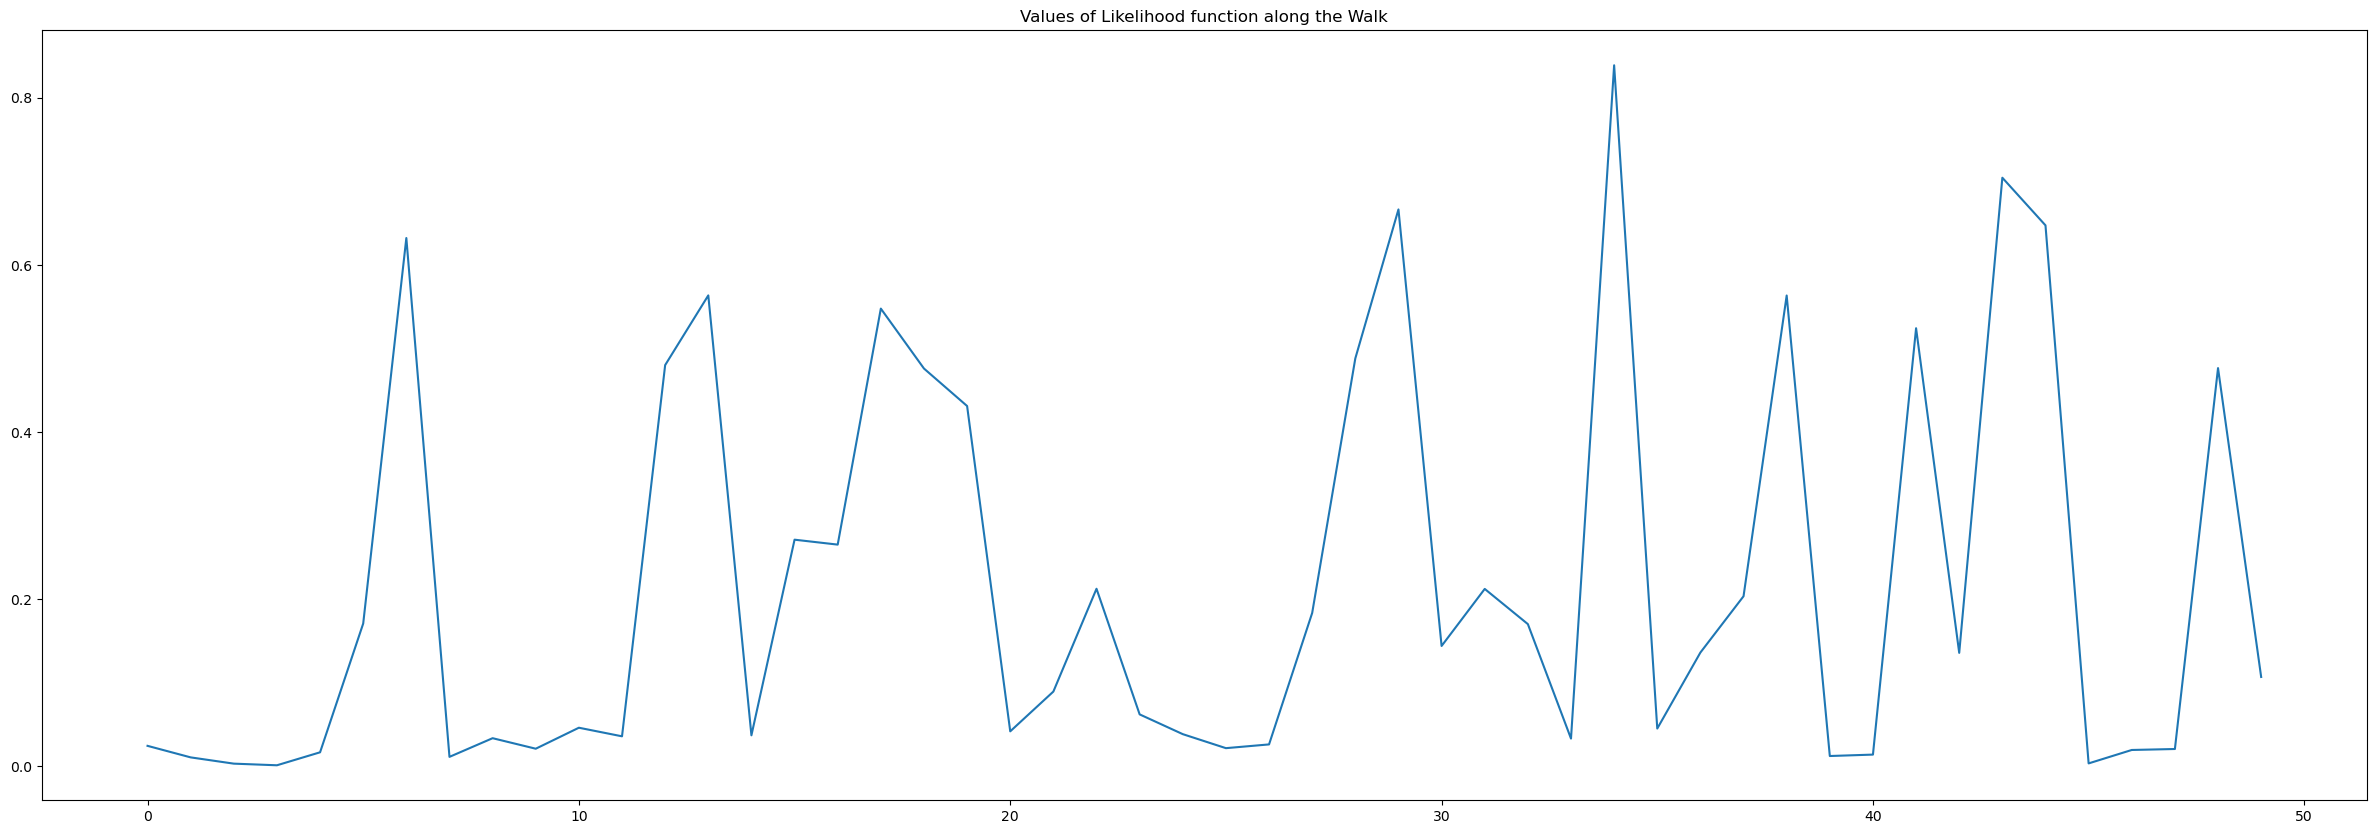

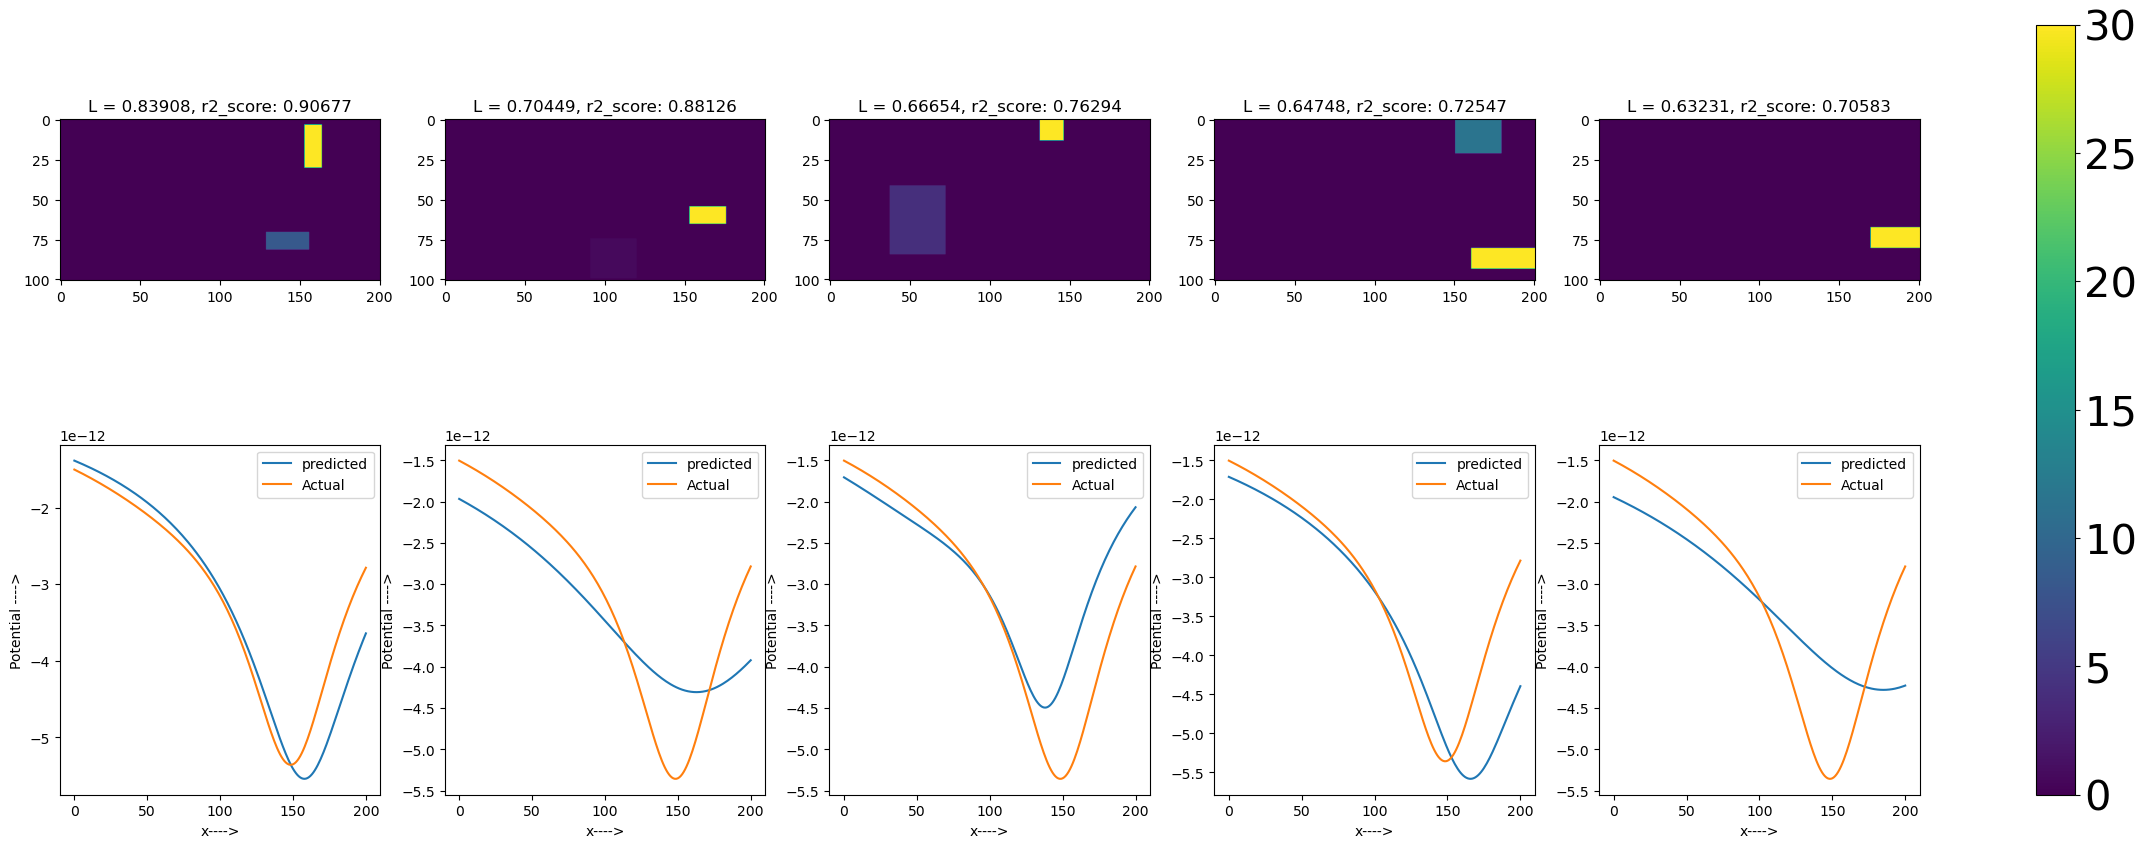

In [278]:
# Use the value that has the highest likelihood for the plots
from sklearn.metrics import r2_score
L_max = np.max(l_values)

plt.rcParams['figure.figsize'] = [30, 10]

print("Acceptance ratio {}".format(acceptance_ratio)) #Print the acceptance ratio

plt.plot(l_values)
plt.title('Values of Likelihood function along the Walk')  #Plot how the values of likelihood changed along the selected samples
plt.show()

index_sorted_L_array = np.argsort(l_values)  # Sorting and storing in ascending order

fig,ax = plt.subplots(2,5)

x_km = np.arange(0,201,1)

for i in range(1,6,1):
    m_pred = m_array[index_sorted_L_array[-i],:,:]
    im = ax[0,i-1].imshow(m_pred)
    ax[0,i-1].set_title('L = {}, r2_score: {}'.format(round(l_values[index_sorted_L_array[-i]],5), round(r2_score(d, d_pred),5)))
    
    d_pred = G_ @ (np.reshape(m_pred,(20301),order='F'))
    
    ax[1,i-1].plot(x_km,d_pred, label = 'predicted')
    ax[1,i-1].plot(x_km,d, label='Actual')
    ax[1,i-1].set_xlabel('x---->')
    ax[1,i-1].set_ylabel('Potential ---->')
    ax[1,i-1].legend()

cbar = plt.colorbar(im, ax = ax.ravel().tolist())
cbar.ax.tick_params(labelsize=30)
plt.show()   


In [279]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def Plot_walk(index):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(m_array[index])
    ax[0].set_title('Random walk through model space, Selected m index {}'.format(index+1))
    
    d_pred = G_ @ (np.reshape(m_array[index],(20301),order='F'))
    ax[1].plot(x_km,d, label='Actual')
    ax[1].set_xlabel('x---->')
    ax[1].set_ylabel('Potential ---->')

print("Slider: ")
interact(Plot_walk, index=(0,num_samples-1,1))

Slider: 


interactive(children=(IntSlider(value=24, description='index', max=49), Output()), _dom_classes=('widget-inter…

<function __main__.Plot_walk(index)>

*The acceptance ratio should be between 0.3 - 0.5. As it is clearly visible it is better to go with the dependent sampling due to the increase in efficiency.*

## 3) Effect of changing the variance in data

d_sigma = 1.0, Acceptance_ratio = 0.1789709172259508, max Likelihood = 0.6055331207444875
d_sigma = 1.5, Acceptance_ratio = 0.24242424242424243, max Likelihood = 0.49842889414851665
d_sigma = 2.0, Acceptance_ratio = 0.3252032520325203, max Likelihood = 0.7045906510588629
d_sigma = 2.5, Acceptance_ratio = 0.5797101449275363, max Likelihood = 0.6683580805613626
d_sigma = 3.0, Acceptance_ratio = 0.5673758865248227, max Likelihood = 0.6868672245993327
d_sigma = 3.5, Acceptance_ratio = 0.6504065040650406, max Likelihood = 0.8784315375910657
d_sigma = 4.0, Acceptance_ratio = 0.5633802816901409, max Likelihood = 0.8250218328804748
d_sigma = 4.5, Acceptance_ratio = 0.6611570247933884, max Likelihood = 0.9226054444569154
d_sigma = 5.0, Acceptance_ratio = 0.7142857142857143, max Likelihood = 0.9491981770272733
d_sigma = 5.5, Acceptance_ratio = 0.7207207207207207, max Likelihood = 0.8948954253704853
d_sigma = 6.0, Acceptance_ratio = 0.6837606837606838, max Likelihood = 0.902734471145187


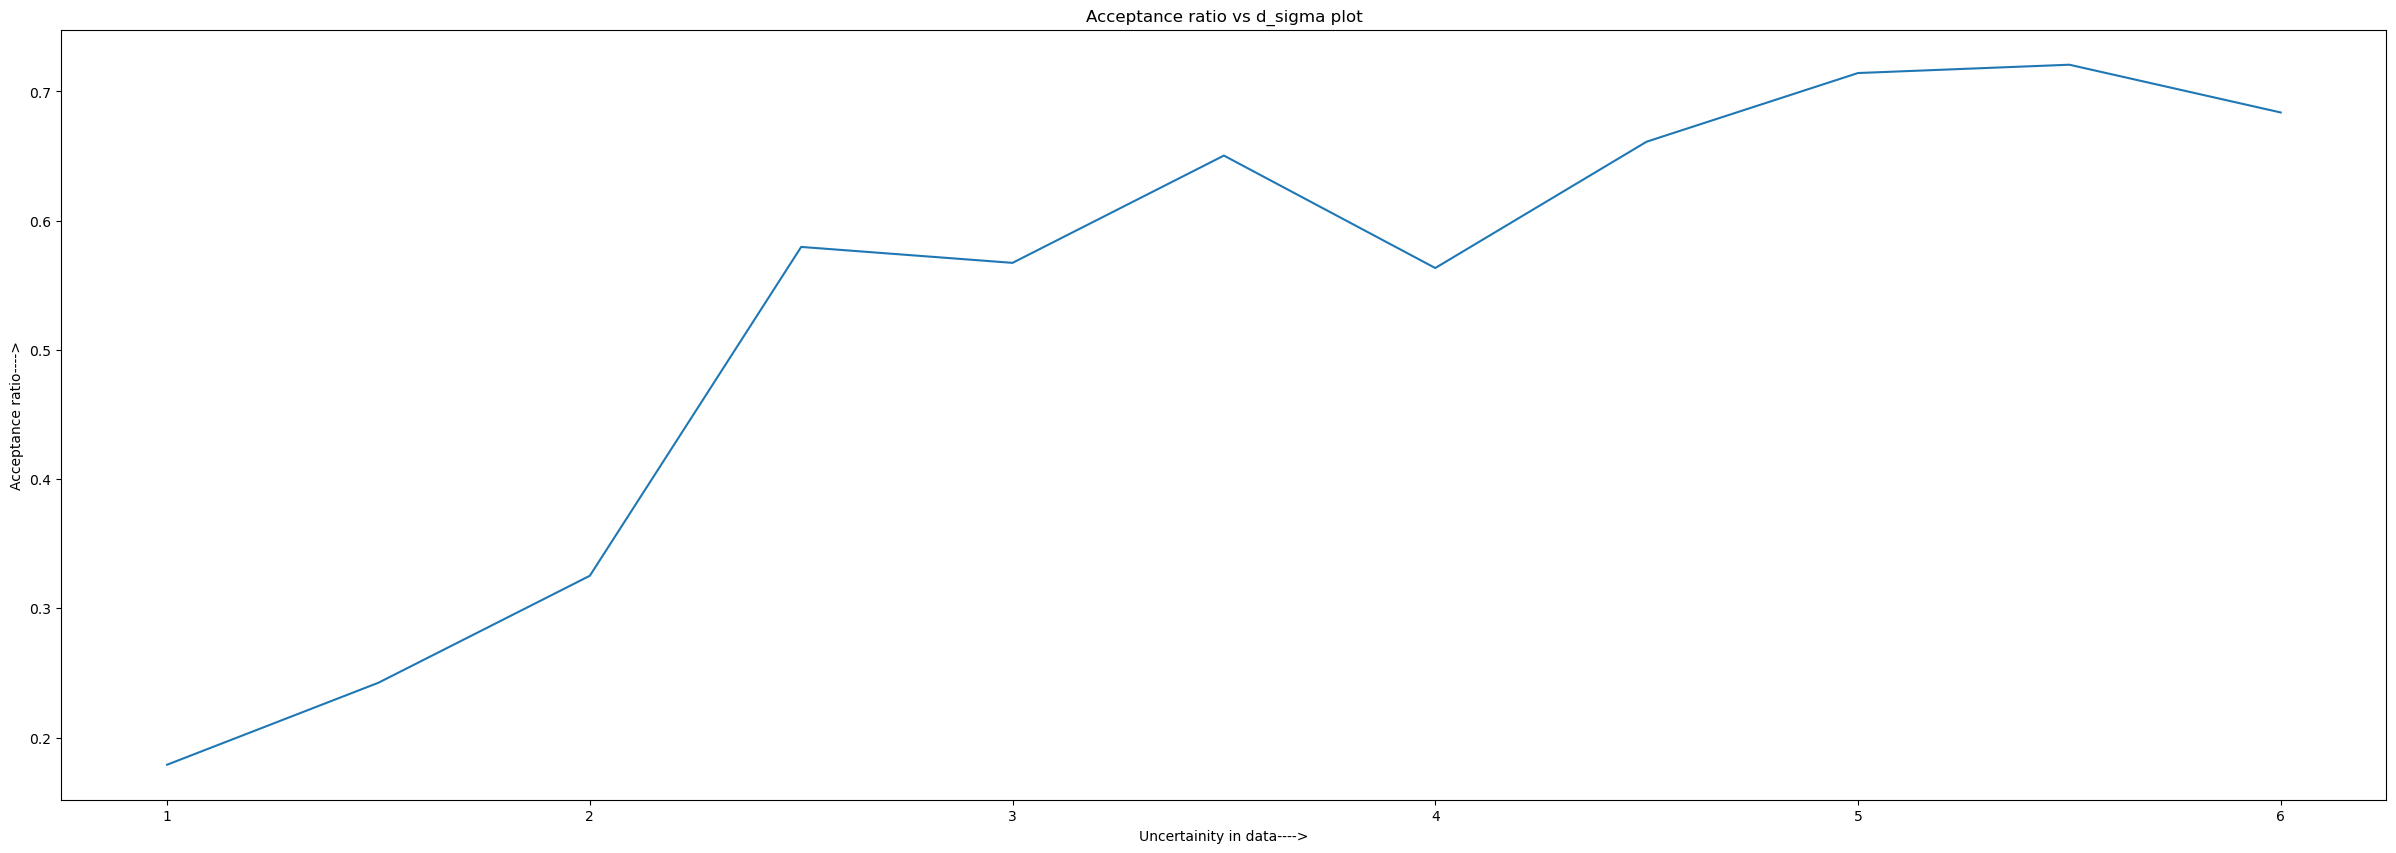

In [282]:

num_samples =  80  #Number of samples to generate, runtime will increase as samples are increased

d_sigma_array = np.array([1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6])
ac_ratio_list = np.zeros(len(d_sigma_array))

for i in range(len(d_sigma_array)):
    Output = random_walk_metropolis(toggle_metro = 1, # turn the 2nd case on/off, '0' is take only the more likelihood samples
                                    dependent = 1,
                                    m0 = m0, 
                                    properties_m0 = properties_m0, 
                                    d_obs = d, 
                                    sigma_center = 8, # Uncertainity in the centres of rectangle
                                    sigma_density = 10, # Uncertainity in density
                                    sigma_size = 1, # Uncertainity in size of the the rectangles
                                    d_sigma = d_sigma_array[i], # Standard deviation in data(works on the scaled data)
                                    n_samples = num_samples)

    m_array, l_values, acceptance_ratio, properties_array = Output[0],Output[1],Output[2],Output[3]
    
    
    print('d_sigma = {}, Acceptance_ratio = {}, max Likelihood = {}'.format(d_sigma_array[i], acceptance_ratio, np.max(l_values)))
    ac_ratio_list[i] = acceptance_ratio

plt.plot(d_sigma_array, ac_ratio_list)
plt.xlabel('Uncertainity in data---->')
plt.ylabel('Acceptance ratio---->')
plt.title("Acceptance ratio vs d_sigma plot")
plt.show()

It can be observed that there is a an increasing trend for acceptance value as uncertainity/spread in data is increased.

Text(0, 0.5, 'Likelihood for the same error')

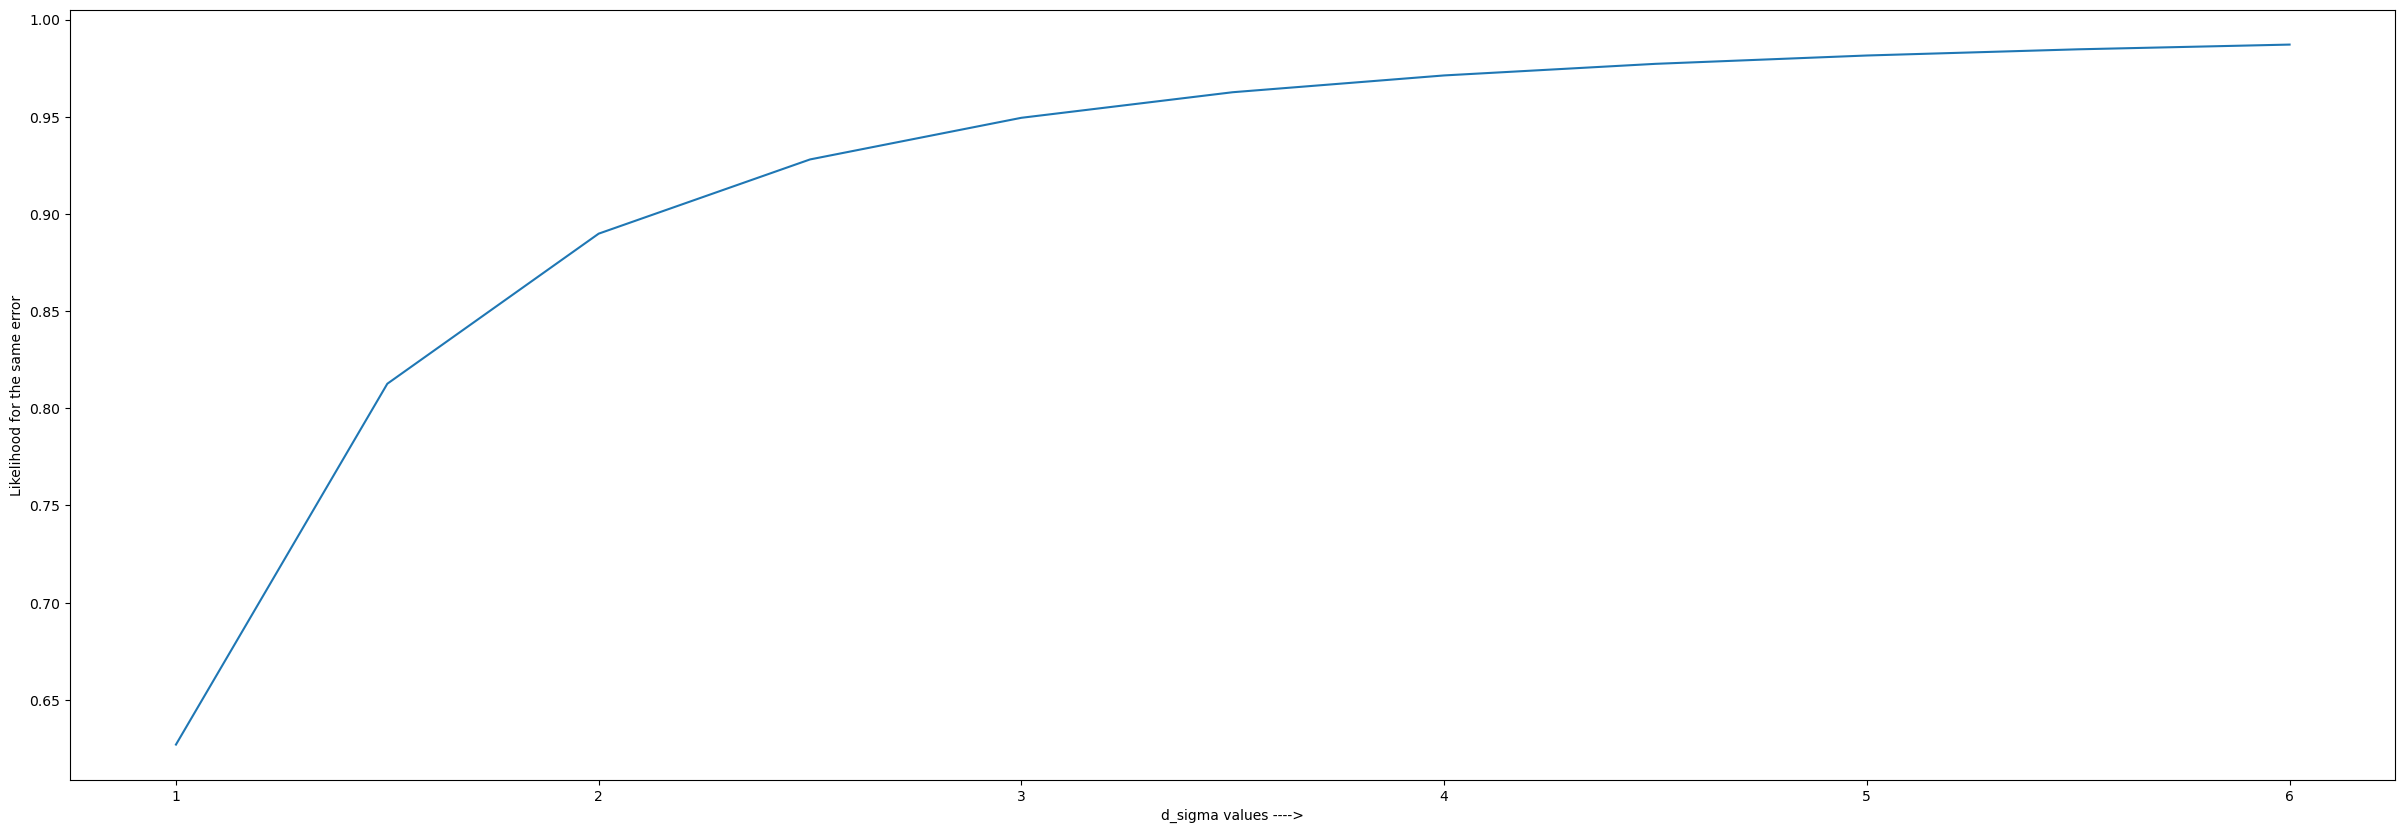

In [283]:
L_values = np.zeros(len(d_sigma_array))
i = 0
for d_sig in d_sigma_array:
    L_values[i] = Likelihood_m(0.9*d,d,d_sig)
    i+=1
plt.plot(d_sigma_array, L_values)
plt.xlabel('d_sigma values ---->')
plt.ylabel('Likelihood for the same error')

The likelihood function gives higher value for the same error when uncertainity in d is increased